In [1]:
import pegasos
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
import pdb
import random
from tqdm import tqdm
from time import time
from sklearn import linear_model
from sklearn import svm as sklearn_svm
from sklearn.preprocessing import StandardScaler



# Keras imports
import keras
from keras.models import load_model, Sequential, Model
from keras.layers import Dropout, Dense, Conv2D, Flatten, MaxPooling2D, Activation, Input, LeakyReLU, BatchNormalization
from keras.callbacks import ModelCheckpoint

PEGASOS_CLF = classifier = pegasos.PegasosSVMClassifier()
PEGASOS_CLF.fit(np.zeros((2, 1024)), np.asarray([1, 0]))

def plot_pr(y_test, y_gt, title=' '):
    average_precision = average_precision_score(y_gt, y_test)
    precision, recall, _ = precision_recall_curve(y_gt, y_test)

    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.5, color='b')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title + ' PR curve: AUC={0:0.2f}'.format(average_precision))
    plt.show()
    
def plot_all(X1, Y, Y_model, gt, title=' '):
    # Get Average precisions for all
    ap_x1 = round(average_precision_score(gt, X1), 2)
    ap_y = round(average_precision_score(gt, Y), 2)
    ap_y_model = round(average_precision_score(gt, Y_model), 2)
    
    # Get PR for all
    precision_x1, recall_x1, _ = precision_recall_curve(gt, X1)
    precision_y, recall_y, _ = precision_recall_curve(gt, Y)
    precision_y_model, recall_y_model, _ = precision_recall_curve(gt, Y_model)

    plt.step(recall_x1, precision_x1, color='b', alpha=1.0, where='post', label='X1')
    plt.step(recall_y, precision_y, color='g', alpha=1.0, where='post', label='GT')
    plt.step(recall_y_model, precision_y_model, color='r', alpha=1.0, where='post', label='Model')
    plt.legend()
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title + ' AUC=%.2f|%.2f|%.2f'%(ap_x1, ap_y, ap_y_model))
    plt.show()
    
class SVM_Triplet:
    def __init__(self, X1, X2, Y, base_classes, pos_class, novel_class):
        self.X1 = X1
        self.X2 = X2
        self.Y = Y
        self.base_classes = base_classes
        self.pos_class = pos_class
        self.novel_class = novel_class

def prepare_features(pos_class, neg_classes, feature_vectors, is_train=True, 
                     equal_features=False, train_split=0.9):
    '''
    Returns 4096-dim features for each image which would be used for SVM training
    inputs : 
        is_train -> will return 90% of features for each class if is_train=True, else returns 10% features
        equal_features -> if set to True, then len(neg_features) = len(pos_features)
    
    Returns:
        pos_features -> features of images in the positive class
        neg_features -> features of images in the negative classes
    '''
    
    pos_partition = int(train_split*feature_vectors[pos_class].shape[0])
    neg_features = []
    if is_train:
        pos_features = feature_vectors[pos_class][:pos_partition]    # n x 4096
        for neg_class in neg_classes:
            neg_partition = int(train_split*feature_vectors[neg_class].shape[0])
            neg_features.extend(feature_vectors[neg_class][:neg_partition])
            
    else:
        pos_features = feature_vectors[pos_class][pos_partition:]    # n x 4096
        for neg_class in neg_classes:
            neg_partition = int(train_split*feature_vectors[neg_class].shape[0])
            neg_features.extend(feature_vectors[neg_class][neg_partition:])
             
    if equal_features:
        neg_features = np.random.permutation(neg_features)[:pos_features.shape[0]]
    
    return pos_features, neg_features

'''
Following function replaced with model.score(test_X, test_y)
'''
def compute_accuracy(weight_vector, pos_features, neg_features):
# #     classifier = pegasos.PegasosSVMClassifier()
# #     classifier.fit(np.zeros((2, 1024)), np.asarray([1, 0]))
#     PEGASOS_CLF.weight_vector.weights = weight_vector

#     # Concat data and pass to SVM
#     result = PEGASOS_CLF.predict(np.vstack((pos_features, neg_features)))
#     ground_truth = np.concatenate((np.ones(len(pos_features)), np.zeros(len(neg_features))))
#     return np.average(np.equal(ground_truth, result)), result, ground_truth
    pass

def get_svm_weights(x_train, y_train, sklearn_SGD=False):
    if sklearn_SGD:
        clf = linear_model.SGDClassifier()
        clf.partial_fit(x_train, y_train, classes=np.unique(y_train))
        weights = clf.coef_
        return clf
    else:
        clf = pegasos.PegasosLogisticRegression()
        clf.fit(x_train, y_train)
        return clf


def get_x_y(pos_features, neg_features):
    x = np.vstack((pos_features, neg_features))
    y = np.hstack((np.ones( len(pos_features)),
                   np.zeros(len(neg_features))))
    return x, y


'''
We only need the negative features for the novel class. 
(It is negative with respect to the positive class)
'''
def online_svm_update(clf, neg_features):
    clf.partial_fit(neg_features, np.zeros(len(neg_features)))
    return clf
    

'''
SVM for novel class. 
pos_class = pos_class
neg_classes = base_classes - pos_class
'''
def compute_X1(pos_class, base_classes, feature_vectors, is_train=True, sklearn_SGD=False):
    neg_classes = np.delete(base_classes, np.argwhere(base_classes==pos_class))
    pos_features, neg_features = prepare_features(pos_class, neg_classes, feature_vectors, is_train=is_train)
    x_train, y_train = get_x_y(pos_features, neg_features)
    return get_svm_weights(x_train, y_train, sklearn_SGD=sklearn_SGD)
    

'''
SVM for novel class. 
pos_class = novel_class
neg_classes = base_classes
'''
def compute_X2(novel_class, base_classes, feature_vectors, is_train=True, sklearn_SGD=False):
    pos_features, neg_features = prepare_features(novel_class, base_classes, feature_vectors, is_train=is_train)
    x_train, y_train = get_x_y(pos_features, neg_features)
    return get_svm_weights(x_train, y_train, sklearn_SGD=sklearn_SGD)
    
'''
SVM for pos class under the influence of the neg class. 
pos_class = pos_class
neg_classes = base_classes - pos_class + novel_class
'''
def compute_Y(pos_class, novel_class, base_classes, feature_vectors, is_train=True, sklearn_SGD=False):
    neg_classes = np.delete(base_classes, np.argwhere(base_classes==pos_class))
    neg_classes = np.append(neg_classes, novel_class)
    pos_features, neg_features = prepare_features(pos_class, neg_classes, feature_vectors, is_train=is_train)
    x_train, y_train = get_x_y(pos_features, neg_features)
    return get_svm_weights(x_train, y_train, sklearn_SGD=sklearn_SGD)


def get_probs(clf, X):
    p = np.dot(clf.weight_vector.weights, X.T) * clf.weight_vector.scale
    probs = np.exp(p) / (1.0 + np.exp(p))
    return probs


Using TensorFlow backend.


In [2]:
FEATURE_FILE = '/media/red/capstone/data/stanford_40/vgg16_features.pkl'
NORMALIZED_FEATURE_FILE = '/media/red/capstone/data/stanford_40/vgg16_features_normalized.pkl'
TRIPLETS_FILE = '/media/red/capstone/data/stanford_triplets_pegasos_100k_logistic.pkl'
TRIPLETS_FILE_2 = '/media/red/capstone/data/stanford_triplets_sklearn_plus2.pkl'
VAL_TRIPLETS = '/media/red/capstone/data/stanford_triplets_pegasos_logistic_val.pkl'


features, file_names, scaler = pickle.load(open(NORMALIZED_FEATURE_FILE, "rb"))

'''
Following commented code was used to scale and shift the feature vectors. Very important!
'''
# all_feat = np.array([], dtype=np.float64).reshape(0,4096)

# # Scale feature vectors
# for cls in features.keys():
#     all_feat = np.vstack((all_feat, features[cls]))    # Stack vertically
# scaler = StandardScaler()
# all_feat = scaler.fit_transform(all_feat)
# features_normalized = {}
# i = 0
# for cls in features.keys():
#     features_normalized[cls]=all_feat[i:i+features[cls].shape[0]]
#     i += features[cls].shape[0]

# features = features_normalized

# with open(NORMALIZED_FEATURE_FILE, 'wb') as f:
#     pickle.dump((features, file_names, scaler), f)

seed = 1234
random.seed(seed)
np.random.seed(seed)

# Splitting classes into train/val/test
labels = np.array(list(features.keys()))
perm = np.random.permutation(len(labels))
labels = labels[perm]

splits = {}
splits['base']=labels[:15]
splits['novel'] = labels[15:25]
splits['test']=labels[25:]

print(splits)

{'base': array(['phoning', 'rowing_a_boat', 'cutting_vegetables', 'waving_hands',
       'riding_a_bike', 'writing_on_a_board', 'running', 'throwing_frisby',
       'taking_photos', 'jumping', 'looking_through_a_microscope',
       'playing_guitar', 'looking_through_a_telescope', 'fixing_a_car',
       'gardening'],
      dtype='<U28'), 'novel': array(['holding_an_umbrella', 'walking_the_dog', 'playing_violin',
       'pushing_a_cart', 'riding_a_horse', 'smoking', 'fixing_a_bike',
       'writing_on_a_book', 'texting_message', 'feeding_a_horse'],
      dtype='<U28'), 'test': array(['cleaning_the_floor', 'brushing_teeth', 'cutting_trees', 'cooking',
       'climbing', 'reading', 'drinking', 'washing_dishes',
       'shooting_an_arrow', 'watching_TV', 'using_a_computer',
       'blowing_bubbles', 'pouring_liquid', 'fishing', 'applauding'],
      dtype='<U28')}


## Online SVM Baseline (10 + 1)

In [ ]:
# For PR curves
X1_preds=[]
gts = []
Y_preds = []
Y_online_preds = []


for i in tqdm(range(10)):
    
    base_class_ind = np.random.permutation(len(splits['base']))[:10]
    base_classes = splits['base'][base_class_ind]
    pos_class = np.random.choice(base_classes)
    novel_class = np.random.choice(splits['test'])
    
    # SVM weights of pos class
    clf_X1 = compute_X1(pos_class, base_classes, features, is_train=True, sklearn_SGD=True)
    X1 = clf_X1.coef_
    
    # SVM weights of novel class
    clf_X2 = compute_X2(novel_class, base_classes, features, is_train=True, sklearn_SGD=True)
    X2 = clf_X2.coef_
    
    # SVM weights of pos class under the influence of novel class
    clf_Y = compute_Y(pos_class, novel_class, base_classes, features, is_train=True, sklearn_SGD=True)
    Y = clf_Y.coef_

    
    neg_classes = np.delete(base_classes, np.argwhere(base_classes==pos_class))
    neg_classes_extra = np.append(neg_classes, novel_class)    # 9 + 1 classes
    pos_features_test, neg_features_test = prepare_features(pos_class, 
                                                            neg_classes_extra, 
                                                            features, 
                                                            is_train=False, 
                                                            equal_features=False)
    gt = np.concatenate((np.ones(len(pos_features_test)), np.zeros(len(neg_features_test))))
    
    # Mean accuracies
    to_predict = np.vstack((pos_features_test, neg_features_test))
#     acc1 = clf_X1.score(to_predict, gt)
#     acc2 = clf_Y.score(to_predict, gt)
                           
    # Need the predictions for PR curves
    X1_pred = clf_X1.predict(to_predict)
    Y_pred = clf_Y.predict(to_predict)
                           
    # Online SVM update
#     neg_partition = int(0.9*features[novel_class].shape[0])
#     neg_features = features[novel_class][:neg_partition]
#     clf_Y_online = online_svm_update(clf_X1, neg_features)
#     Y_online = clf_Y_online.coef_
# #     acc3 = clf_Y_online.score(to_predict, gt)  
#     Y_pred_online = clf_Y_online.predict(to_predict)
    
#     print('%.5f %.5f %.5f' % (acc1,acc2, acc3))                       

    # PR curve stuff
    X1_preds.extend(X1_pred.tolist())
    Y_preds.extend(Y_pred.tolist())
#     Y_online_preds.extend(Y_pred_online.tolist())
    gts.extend(gt.tolist())
    
plot_pr(X1_preds, gts, 'X1')
plot_pr(Y_preds, gts, 'GT - Y')
# plot_pr(Y_online_preds, gts)
    

## Online SVM (10 + 2)

In [ ]:
# For PR curves
X1_preds=[]
gts = []
Y_preds = []
Y_online_preds = []

for i in tqdm(range(1000)):
    
    base_class_ind = np.random.permutation(len(splits['base']))[:10]
    base_classes = splits['base'][base_class_ind]
    pos_class = np.random.choice(base_classes)
    novel_class_1 = np.random.choice(splits['test'])
    novel_class_2 = np.random.choice(np.delete(splits['test'], np.argwhere(splits['test']==novel_class_1)))
    
    # SVM weights of pos class
    clf_X1 = compute_X1(pos_class, base_classes, features, is_train=True, sklearn_SGD=True)
    
    # SVM weights of pos class under the influence of novel class
    neg_classes = np.delete(base_classes, np.argwhere(base_classes==pos_class))
    neg_classes = np.append(neg_classes, novel_class_1)
    neg_classes = np.append(neg_classes, novel_class_2)
    
    pos_features_train, neg_features_train = prepare_features(pos_class, neg_classes, features, is_train=True)
    x_train, y_train = get_x_y(pos_features_train, neg_features_train)
    clf_Y = get_svm_weights(x_train, y_train, sklearn_SGD=True)
    
    
    pos_features_test, neg_features_test = prepare_features(pos_class, 
                                                            neg_classes, 
                                                            features, 
                                                            is_train=False, 
                                                            equal_features=False)
    gt = np.concatenate((np.ones(len(pos_features_test)), np.zeros(len(neg_features_test))))
    
    to_predict = np.vstack((pos_features_test, neg_features_test))
    
                           
    # Need the predictions for PR curves
    X1_pred = clf_X1.predict(to_predict)
    Y_pred = clf_Y.predict(to_predict)
                           
    # Online SVM update
    # First for novel class 1
    neg_partition = int(0.9*features[novel_class_1].shape[0])
    neg_features = features[novel_class_1][:neg_partition]
    clf_Y_online = online_svm_update(clf_X1, neg_features)
    
    # Now for novel class 2
    neg_partition = int(0.9*features[novel_class_2].shape[0])
    neg_features = features[novel_class_2][:neg_partition]
    clf_Y_online = online_svm_update(clf_Y_online, neg_features) 
    Y_pred_online = clf_Y_online.predict(to_predict)
                        

    # PR curve stuff
    X1_preds.extend(X1_pred.tolist())
    Y_preds.extend(Y_pred.tolist())
    Y_online_preds.extend(Y_pred_online.tolist())
    gts.extend(gt.tolist())
    
plot_pr(X1_preds, gts)
plot_pr(Y_preds, gts)
plot_pr(Y_online_preds, gts)

## Create 10+1 triplets for ground truth

In [ ]:
NUM_SIMULATIONS = 100000
triplets = []

for i in tqdm(range(int(NUM_SIMULATIONS/100))):
    base_class_ind = np.random.permutation(len(splits['base']))[:10]
    base_classes = splits['base'][base_class_ind]
    
    X1s = {}
    for pos_class in base_classes:
        start = time()
        X1s[pos_class] = compute_X1(pos_class, base_classes, features, is_train=True, sklearn_SGD=False)
    
    X2s = {}
    for novel_class in splits['novel']:
        X2s[novel_class] = compute_X2(novel_class, base_classes, features, is_train=True, sklearn_SGD=False)

    
    # The following code generates 100 triplets - 10 pos classes x 10 novel classes for each pos class
    for pos_class in base_classes:
        X1 = X1s[pos_class]
        for new_class in splits['novel']:
            
            X2 = X2s[novel_class]
            Y = compute_Y(pos_class, novel_class, base_classes, features, is_train=True, sklearn_SGD=False)
            
            # Sanity check
            neg_classes = np.delete(base_classes, np.argwhere(base_classes==pos_class))
            neg_classes = np.append(neg_classes, novel_class)
            pos_features_test, neg_features_test = prepare_features(pos_class, 
                                                                    neg_classes, 
                                                                    features, 
                                                                    is_train=False, 
                                                                    equal_features=False)
            
#             acc1, X1_pred, _ = compute_accuracy(X1, pos_features_test, neg_features_test)
#             acc2, Y_pred, _ = compute_accuracy(Y, pos_features_test, neg_features_test)
            gt = np.concatenate((np.ones(len(pos_features_test)), np.zeros(len(neg_features_test))))
            to_predict = np.vstack((pos_features_test, neg_features_test))
            acc1 = X1.score(to_predict, gt)
            acc2 = Y.score(to_predict, gt)
            print(acc1, acc2)

#             pdb.set_trace()
            triplets.append(SVM_Triplet(X1, X2, Y, base_classes, pos_class, novel_class))
        
#     if i % 10000 == 0:
#         with open(TRIPLETS_FILE, 'wb') as f:
#             pickle.dump(triplets, f)


## Training the regressor network

In [3]:
# Prepare data for training
triplets_train = pickle.load(open(TRIPLETS_FILE, "rb"))
triplets_val = pickle.load(open(VAL_TRIPLETS, "rb"))
print('Loaded %d training triplets'%(len(triplets_train)))
print('Loaded %d validation triplets'%(len(triplets_val)))

Loaded 44300 training triplets
Loaded 19050 validation triplets


In [ ]:
# Sanity checks on logistic dataset
# np.linalg.norm(triplets[0].Y.weight_vector.weights)
# print(triplets[0].Y.weight_vector.scale)
# print(triplets[0].X1.weight_vector.scale)
# print(triplets[0].X2.weight_vector.scale)


# print(np.linalg.norm(triplets[705].Y.weight_vector.scale * triplets[705].Y.weight_vector.weights))
# print(np.linalg.norm(triplets[705].X1.weight_vector.scale * triplets[705].X1.weight_vector.weights))
# print(np.linalg.norm(triplets[705].X2.weight_vector.scale * triplets[705].X2.weight_vector.weights))

# PR Curves
ind = 1000
print(triplets[ind].pos_class)
neg_classes = np.delete(triplets[ind].base_classes, np.argwhere(triplets[ind].base_classes==triplets[ind].pos_class))
neg_classes = np.append(neg_classes, triplets[ind].novel_class)    # 9 + 1 classes
pos_features_test, neg_features_test = prepare_features(triplets[ind].pos_class, 
                                                        neg_classes, 
                                                        features, 
                                                        is_train=False, 
                                                        equal_features=False)
    
    
gt = np.concatenate((np.ones(len(pos_features_test)), np.zeros(len(neg_features_test))))
to_predict = np.vstack((pos_features_test, neg_features_test))


p = np.dot(triplets[ind].Y.weight_vector.weights, to_predict.T) * triplets[ind].Y.weight_vector.scale
probs = np.exp(p) / (1.0 + np.exp(p))
plot_pr(probs, gt)

p = np.dot(triplets[ind].X1.weight_vector.weights, to_predict.T) * triplets[ind].X1.weight_vector.scale
probs = np.exp(p) / (1.0 + np.exp(p))
plot_pr(probs, gt)

In [ ]:
'''
Prepare data for training
'''
normalize = False
X_train, Y_train = [], []
for triplet in tqdm(triplets_train):
    
    ### NORMALIZE X1, X2 and Y here!!!
    if normalize:
        X1 = triplet.X1 / np.linalg.norm(triplet.X1, axis=0, keepdims=True)
        X2 = triplet.X2 / np.linalg.norm(triplet.X2, axis=0, keepdims=True)
        Y  = triplet.Y  / np.linalg.norm(triplet.Y,  axis=0, keepdims=True)
        X_train.append(np.hstack((X1, X2)))
        Y_train.append(np.array(Y-X1))
    
    else:   
        X1 = triplet.X1.weight_vector.weights * triplet.X1.weight_vector.scale
        X2 = triplet.X2.weight_vector.weights * triplet.X2.weight_vector.scale
        Y = triplet.Y.weight_vector.weights * triplet.Y.weight_vector.scale
        X_train.append(np.hstack((X1, X2)).flatten())
        Y_train.append(np.array(Y-X1).flatten())


In [ ]:
'''
Define the architecture
'''
FEATURE_SHAPE = 4096
inp = Input(shape=(FEATURE_SHAPE * 2,))
x = Dense(int(FEATURE_SHAPE * 3), name='dense_1', activation='relu')(inp)
x = Dropout(0.1)(x)
x = Dense(int(FEATURE_SHAPE * 2.5), name='dense_2', activation='relu')(x)
x = Dropout(0.1)(x)
x = Dense(FEATURE_SHAPE, name='dense_3', activation='relu')(x)
x = Dense(FEATURE_SHAPE, name='dense_4')(x)

model = Model(inputs=inp, outputs=x)

optimizer = keras.optimizers.Adam(lr=0.0001)

model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])

    
SAVE_FILE =  'stanford_logistic_drop_adam_L2_42k_lr4_{epoch:02d}-{acc:.2f}.h5'   
    
checkpoint = ModelCheckpoint(SAVE_FILE, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

model.fit(np.array(X_train), 
          np.array(Y_train), 
          epochs=25, 
          batch_size=32, 
          shuffle=True, 
          verbose=1,
          callbacks=callbacks_list,
          validation_split=0.01)
# model.save('mit_e100_rms_cosine_100k_nobn.h5')

## Get PR of trained model

In [ ]:
# For PR curves
model = load_model('stanford_logistic_adam_L2_26k_lr4_09-0.66.h5')
X1_predictions = []
gt_predictions = []
model_predictions = []
gts = []


for q in tqdm(range(10)):
    
    t = np.random.permutation(25000)
    i = t[0]
    
    base_class_ind = np.random.permutation(len(splits['base']))[:10]
#     base_classes = splits['base'][base_class_ind]
    base_classes = triplets[i].base_classes
    pos_class = triplets[i].pos_class
    novel_class = triplets[i].novel_class
#     pos_class = np.random.choice(base_classes)
#     novel_class = np.random.choice(splits['test'])
    
    # SVM weights of pos class
#     X1 = compute_X1(pos_class, base_classes, features, is_train=True, sklearn_SGD=False)
    X1 = triplets[i].X1

    
    # SVM weights of novel class
#     X2 = compute_X2(novel_class, base_classes, features, is_train=True, sklearn_SGD=False)
    X2 = triplets[i].X2
    
    # SVM weights of pos class under the influence of novel class (GT)
#     Y = compute_Y(pos_class, novel_class, base_classes, features, is_train=True, sklearn_SGD=False)
    Y = triplets[i].Y
    
    
    neg_classes = np.delete(base_classes, np.argwhere(base_classes==pos_class))
    neg_classes = np.append(neg_classes, novel_class)    # 9 + 1 classes
    pos_features_test, neg_features_test = prepare_features(pos_class, 
                                                            neg_classes, 
                                                            features, 
                                                            is_train=False, 
                                                            equal_features=False)
    
    
    gt = np.concatenate((np.ones(len(pos_features_test)), np.zeros(len(neg_features_test))))
    to_predict = np.vstack((pos_features_test, neg_features_test))
    
    # Model
    X1_vec = X1.weight_vector.weights * X1.weight_vector.scale
    X2_vec = X2.weight_vector.weights * X2.weight_vector.scale
    Y_vec = Y.weight_vector.weights * Y.weight_vector.scale
    X = np.reshape(np.hstack((X1_vec, X2_vec)), (1, 8192))
    delta = model.predict(X)
    Y_model = delta + X1_vec
    
    # Results on X1, Y and model
    X1_prob = get_probs(X1, to_predict).flatten()
    Y_prob = get_probs(Y, to_predict).flatten()
    
    clf = pegasos.PegasosLogisticRegression()
    clf.fit(np.zeros((2, 4096)), np.asarray([1, 0]))
    clf.weight_vector.weights = Y_model
    clf.weight_vector.scale = 1.0
    Y_model_prob = get_probs(clf, to_predict).flatten()

    
    # PR curve stuff
    X1_predictions.extend(X1_prob.tolist())
    gt_predictions.extend(Y_prob.tolist())
    model_predictions.extend(Y_model_prob.tolist())
    gts.extend(gt.tolist())

plot_all(X1_predictions, gt_predictions, model_predictions, gts, pos_class)


## Get per-class PR curve on validation set

100%|██████████| 1000/1000 [1:57:06<00:00,  6.40s/it]


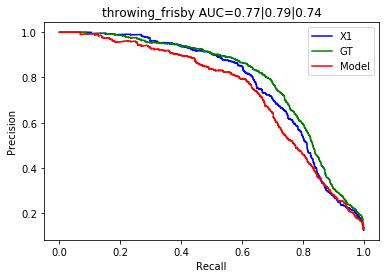

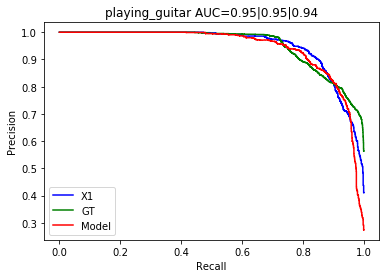

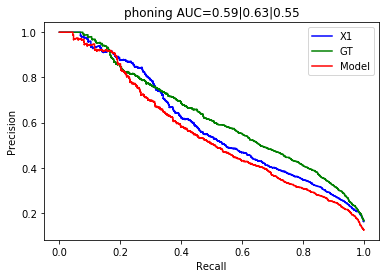

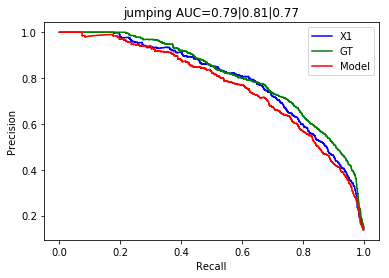

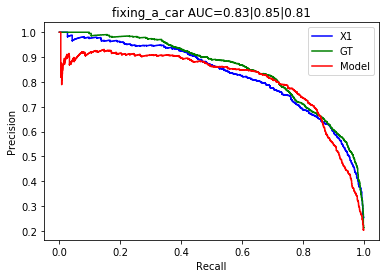

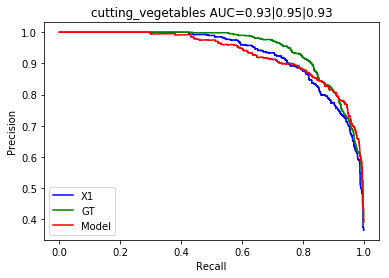

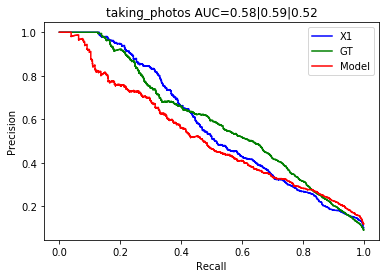

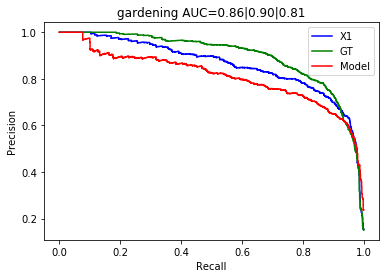

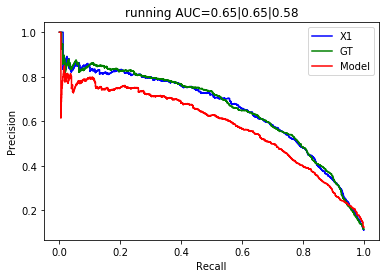

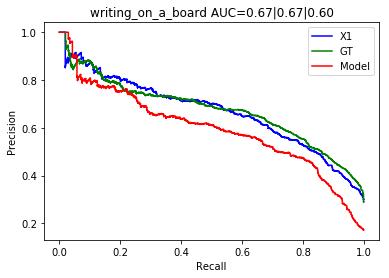

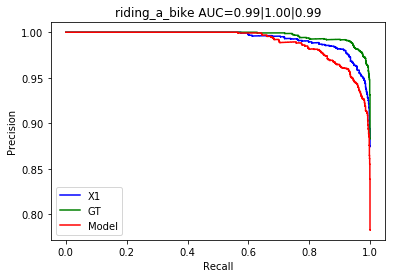

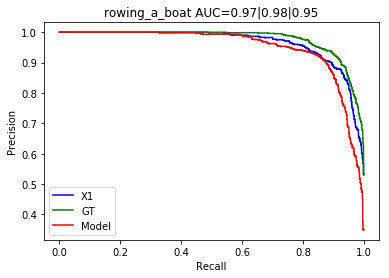

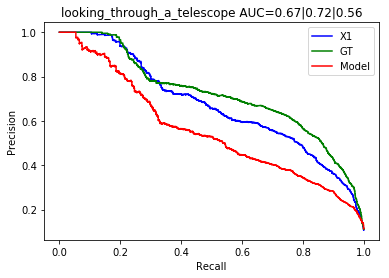

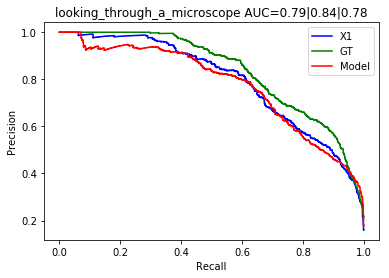

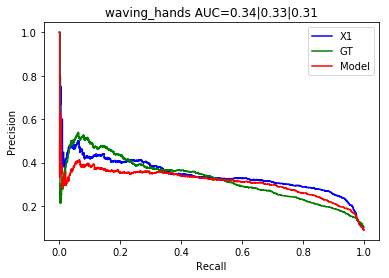

In [4]:
from collections import defaultdict

model = load_model('stanford_logistic_adam_L2_42k_lr4_49-0.73.h5')
X1_predictions = defaultdict(list)
gt_predictions = defaultdict(list)
model_predictions = defaultdict(list)
gts = defaultdict(list)

for q in tqdm(range(len(triplets_val))[:1000]):
    
    t = np.random.permutation(len(triplets_val))
    i = t[0]

    base_classes = triplets_val[i].base_classes
    pos_class = triplets_val[i].pos_class
    novel_class = triplets_val[i].novel_class

    X1 = triplets_val[i].X1
    X2 = triplets_val[i].X2
    Y = triplets_val[i].Y
    
    # Get pos and neg features
    neg_classes = np.delete(base_classes, np.argwhere(base_classes==pos_class))
    neg_classes = np.append(neg_classes, novel_class)    # 9 + 1 classes
    pos_features_test, neg_features_test = prepare_features(pos_class, 
                                                            neg_classes, 
                                                            features, 
                                                            is_train=False, 
                                                            equal_features=False)
    
    
    gt = np.concatenate((np.ones(len(pos_features_test)), np.zeros(len(neg_features_test))))
    to_predict = np.vstack((pos_features_test, neg_features_test))
    
    # Model
    X1_vec = X1.weight_vector.weights * X1.weight_vector.scale
    X2_vec = X2.weight_vector.weights * X2.weight_vector.scale
    Y_vec = Y.weight_vector.weights * Y.weight_vector.scale
    X = np.reshape(np.hstack((X1_vec, X2_vec)), (1, 8192))
    delta = model.predict(X)
    Y_model = delta + X1_vec
    
    # Results on X1, Y and model
    X1_prob = get_probs(X1, to_predict).flatten()
    Y_prob = get_probs(Y, to_predict).flatten()
    
    clf = pegasos.PegasosLogisticRegression()
    clf.fit(np.zeros((2, 4096)), np.asarray([1, 0]))
    clf.weight_vector.weights = Y_model
    clf.weight_vector.scale = 1.0
    Y_model_prob = get_probs(clf, to_predict).flatten()

    
    # PR curve stuff
    X1_predictions[pos_class].extend(X1_prob.tolist())
    gt_predictions[pos_class].extend(Y_prob.tolist())
    model_predictions[pos_class].extend(Y_model_prob.tolist())
    gts[pos_class].extend(gt.tolist())

for pos_class in gts.keys():
    plot_all(X1_predictions[pos_class], gt_predictions[pos_class], model_predictions[pos_class], gts[pos_class], pos_class)

## Get accuracy of trained model

In [ ]:
# Compare our model with the baseline
model = load_model('mit_rms_cosine_100k__lr4_nobn_normalize_04-0.15.h5')
acc1_all, acc2_all = [], []

base_class_ind = np.random.permutation(len(splits['base']))[:10]
base_classes = splits['base'][base_class_ind]
  

for pos_class in base_classes:
    acc1, acc2 = [], []
    X1 = compute_X1(pos_class, base_classes, features, is_train=True)
    X1_norm = X1 / np.linalg.norm(X1, axis=0, keepdims=True)
    neg_classes = np.delete(base_classes, np.argwhere(base_classes==pos_class))
    
    for new_class in splits['test']:
        neg_classes_extra = np.append(neg_classes, new_class)    # 9 + 1 classes
        pos_features_test, neg_features_test = prepare_features(pos_class, 
                                                                neg_classes_extra, 
                                                                features, 
                                                                is_train=False, 
                                                                equal_features=False)
        acc1.append(compute_accuracy(X1, pos_features_test, neg_features_test))

        # Test out our incremental hypothesis
        X2 = compute_X2(new_class, base_classes, features, is_train=True)
        X2_norm = X2 / np.linalg.norm(X2, axis=0, keepdims=True)
        X = np.hstack((X1_norm, X2_norm))
        X = np.reshape(X, (1, 8192))
        Y_hat = model.predict(X)
        Y = X1 + Y_hat.reshape((4096))
        acc2.append(compute_accuracy(Y, pos_features_test, neg_features_test))
        print('%.5f %.5f %.5f %s|%s' % (acc1[-1],acc2[-1], acc2[-1] - acc1[-1], pos_class, new_class)) 

    acc1_all.append(acc1)
    acc2_all.append(acc2)
    
    
acc1_all = np.array(acc1_all)
acc2_all = np.array(acc2_all)
acc1_mean = np.mean(acc1_all, axis=0)
acc2_mean = np.mean(acc2_all, axis=0)


In [ ]:
# Plotting
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
N = len(splits['test'])         # Number of classes
ind = np.arange(N)                # the x locations for the groups
width = 0.35                      # the width of the bars

## the bars
rects1 = ax.bar(ind, acc1_mean, width,color='orange')
rects2 = ax.bar(ind+width, acc2_mean, width, color='green')

# axes and labels
ax.set_xlim(-width,len(ind)+width)
ax.set_ylim(0,1)
ax.set_ylabel('Accuracy')
ax.set_title('Comparision when adding a new class (10 + 1)')
xTickMarks = ['Class ' + str(i) for i in range(0,21)]
ax.set_xticks(ind+width)
xtickNames = ax.set_xticklabels(xTickMarks)
plt.setp(xtickNames, rotation=45, fontsize=12)

## add a legend
ax.legend( (rects1[0], rects2[0]), ('No update', 'SVM weights updated') )

plt.show()

In [ ]:
acc1, acc2 = [], []

for i in range(200):
    base_class_ind = np.random.permutation(len(splits['base']))[:10]
    base_classes = splits['base'][base_class_ind]
    pos_class = np.random.choice(base_classes)
    
    
    X1 = compute_X1(pos_class, base_classes, features, is_train=True)
    neg_classes = np.delete(base_classes, np.argwhere(base_classes==pos_class))


    new_class = np.random.choice(splits['test'])
    neg_classes_extra = np.append(neg_classes, new_class)    # 9 + 1 classes
    pos_features_test, neg_features_test = prepare_features(pos_class, 
                                                            neg_classes_extra, 
                                                            features, 
                                                            is_train=False, 
                                                            equal_features=False)
    

    # Test out our incremental hypothesis
    X2 = compute_X2(new_class, base_classes, features, is_train=True)

    X1_norm = X1 / np.linalg.norm(X1, axis=0, keepdims=True)
    X2_norm = X2 / np.linalg.norm(X2, axis=0, keepdims=True)

    X = np.hstack((X1_norm, X2_norm))
    X = np.reshape(X, (1, 8192))
    Y_hat = model.predict(X)
    Y = X1 + Y_hat.reshape((4096))
    acc1 = compute_accuracy(X1, pos_features_test, neg_features_test)
    acc2 = compute_accuracy(Y, pos_features_test, neg_features_test)
    print('%.5f %.5f %0.3f %s|%s' % (acc1,acc2, acc2-acc1, pos_class, new_class)) 

In [ ]:
print(np.mean(acc1_mean))
print(np.mean(acc2_mean))